# Предсказание CTR 2018

https://www.kaggle.com/c/babushka-ctr-2018

Описание файлов

Вам представлены данные поисковых запросов, по которым была показана контекстная реклама одного рекламодателя.

    train.csv - the training set
    test.csv - the test set.

Поля данных

    RowId - идшник для сабмишена
    AveragePosition - средняя позиция объявления на странице выдачи
    CampaignId - рекламная кампания, обычно содежит объявления одной тематики
    AdGroupId  - содержит группу объявлений, которые показываются при совпадении запроса пользователя (Query) с ключевым словом рекламодателя (описывается KeywordId, сами ключевые слова не включены в датасет)


In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler

In [178]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test_upd.csv")

Переделаем дату в datetime на всякий случай и посчитаем, сколько было сделано и не сделано кликов

In [179]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
train['NotClicks'] = train['Impressions'] - train['Clicks']
train.drop(['Impressions'], axis=1, inplace=True)

Посмотрим на данные

In [180]:
train.head()

,CampaignId,AdGroupId,KeywordId,Query,QueryMatchTypeWithVariant,Device,Date,AveragePosition,Clicks,NotClicks
0,150950690,7953835370,116881275,may loan,NEAR_EXACT,HIGH_END_MOBILE,2016-08-26,1.0,1,0
1,150950690,7953835370,116881275,my lloan,NEAR_EXACT,DESKTOP,2016-09-16,1.0,1,0
2,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-05,2.0,1,0
3,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-12,2.0,1,0
4,150950690,7953835370,116881275,my loan,EXACT,DESKTOP,2016-04-18,1.0,0,1


Перейдем к бинарной классификации. Для этого размножим строки в количестве равном Clicks и NotClicks с соответствующим классом 0 или 1

In [181]:
def reproduce_rows(df):        
    for i, *row, clicks, not_clicks in df.itertuples():
        while clicks > 0:
            yield row + [1]
            clicks -= 1
        while not_clicks > 0:
            yield row + [0]
            not_clicks -= 1
            
columns = list(train.columns.values)   
columns.remove('NotClicks')
train = pd.DataFrame([*reproduce_rows(train)], columns=columns)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569532 entries, 0 to 569531
Data columns (total 9 columns):
CampaignId                   569532 non-null int64
AdGroupId                    569532 non-null int64
KeywordId                    569532 non-null int64
Query                        569532 non-null object
QueryMatchTypeWithVariant    569532 non-null object
Device                       569532 non-null object
Date                         569532 non-null datetime64[ns]
AveragePosition              569532 non-null float64
Clicks                       569532 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 39.1+ MB


Посмотрим на соотношение этих кликов

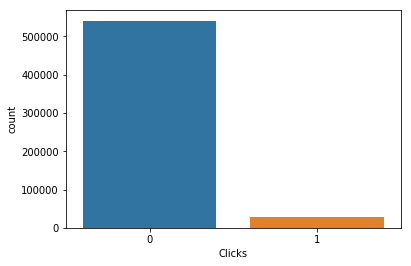

In [182]:
sns.countplot(x="Clicks", data=train)

Посмотрим на данные по кампаниям

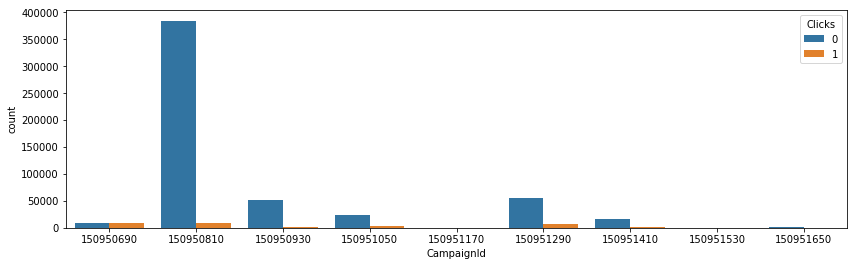

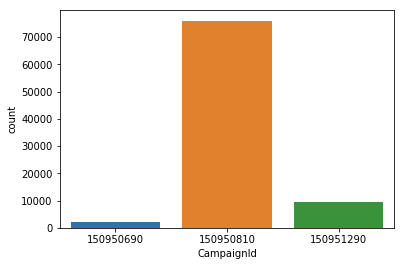

In [183]:
plt.figure(figsize=(14,4))
sns.countplot(x="CampaignId", data=train, hue=train['Clicks'])
plt.show()
sns.countplot(x="CampaignId", data=test)
plt.show()

In [184]:
pd.crosstab(train.CampaignId, train.Clicks, normalize='index')

Clicks,0,1
CampaignId,,
150950690,0.490736,0.509264
150950810,0.979082,0.020918
150950930,0.984000,0.016000
150951050,0.895692,0.104308
150951170,0.732955,0.267045
150951290,0.887885,0.112115
150951410,0.954277,0.045723
150951530,0.936605,0.063395
150951650,0.813084,0.186916


Можно заметить, что в трейновой выборке 9 кампаний, в тестовой 3, причем эти три являются подмножеством кампаний из трейновой. Придется выпилить все кампании не из теста. Кроме того, по рекламам кампании 150950690 наблюдается явная аномалия: количество кликов даже немного больше чем количество "некликов". Посмотрим, по каким запросам она показывается

In [185]:
train = train.loc[train['CampaignId'].isin([150950690, 150950810, 150951290])]
interest_campaign = train.loc[train['CampaignId'] == 150950690]
interest_campaign['Query'].value_counts()[:10]

myloan             11564
my loan             2210
mylan               1401
my loan sverige      265
myloan se            231
mylån                203
www myloan se        159
my lån               132
myloan omdöme        131
mylone               113
Name: Query, dtype: int64

Люди ищут какой-то MyLoan, видимо какие-то кредиты ¯\_(ツ)_/¯

Вообще судя по данным, столбец Query кодируется ключом из столбца KeywordId и точностью его написания QueryMatchTypeWithVariant, так что его можно скипнуть. Взглянем как раз на QueryMatchTypeWithVariant

Clicks,0,1
QueryMatchTypeWithVariant,,
EXACT,0.962038,0.037962
EXPANDED,0.877733,0.122267
NEAR_EXACT,0.814298,0.185702
NEAR_PHRASE,0.734168,0.265832
PHRASE,0.885723,0.114277


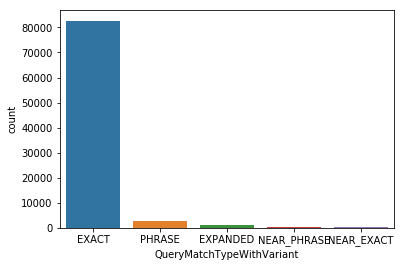

In [186]:
sns.countplot(x="QueryMatchTypeWithVariant", data=test)
pd.crosstab(train.QueryMatchTypeWithVariant, train.Clicks, normalize='index')

Здесь никаких аномалий - по точному вводу кликают чаще и показывается она чаще, по приблизительной фразе кликают реже. Реже всего кликают по Expanded, посмотрим, что это у нас такое

In [187]:
train.loc[train['QueryMatchTypeWithVariant'] == 'EXPANDED']

,CampaignId,AdGroupId,KeywordId,Query,QueryMatchTypeWithVariant,Device,Date,AveragePosition,Clicks
12496,150950690,7953835370,44520786825,how much housing loan i can get for my salary,EXPANDED,DESKTOP,2016-09-05,1.0,1
12501,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-19,1.0,1
12502,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,1
12503,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,0
12504,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,0
12505,150950690,7953835370,44520786825,loan money to my paypal account,EXPANDED,DESKTOP,2016-01-29,1.0,0
12513,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-01-08,1.0,1
12514,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-02-03,1.0,0
12515,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-04-21,1.0,1
12516,150950690,7953835370,44520786825,my car loan,EXPANDED,DESKTOP,2016-04-22,1.0,1


Судя по всему, это запросы, подходящие под тематику рекламы.

Посмотрим на девайсы

Clicks,0,1
Device,,
DESKTOP,0.940015,0.059985
HIGH_END_MOBILE,0.960679,0.039321
TABLET,0.936681,0.063319


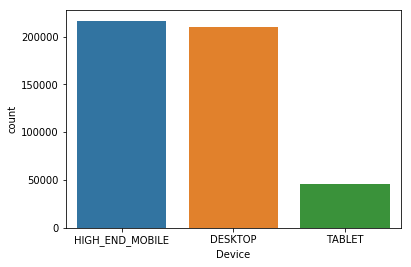

In [188]:
sns.countplot(x="Device", data=train)
pd.crosstab(train.Device, train.Clicks, normalize='index')

Ну тут примерно все одинаково

Средняя позиция вроде как очевидно должна кореллировать с количеством кликов, проверим

Clicks,0,1
AveragePosition,,
1.0,0.787459,0.212541
1.1,0.810670,0.189330
1.2,0.854409,0.145591
1.3,0.878857,0.121143
1.4,0.917642,0.082358
1.5,0.883038,0.116962
1.6,0.948627,0.051373
1.7,0.908412,0.091588
1.8,0.950460,0.049540


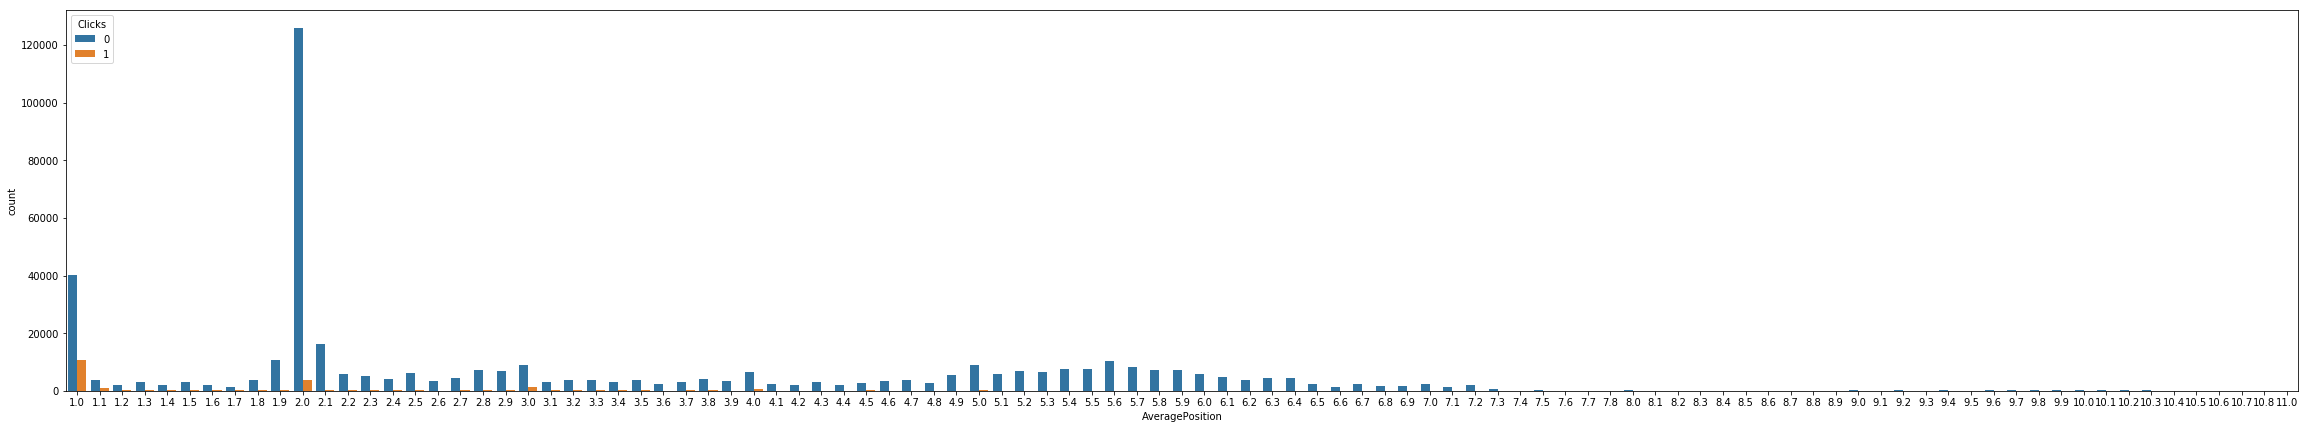

In [189]:
plt.figure(figsize=(40,7))
sns.countplot(x="AveragePosition", data=train, hue='Clicks')
pd.crosstab(train.AveragePosition, train.Clicks, normalize='index')

По сути так и есть. Разберемся со временем

In [190]:
print(train.Date.describe(), '\n', test.Date.describe())

count                  472023
unique                    363
top       2016-06-27 00:00:00
freq                     4826
first     2016-01-01 00:00:00
last      2016-12-31 00:00:00
Name: Date, dtype: object 
 count                   87807
unique                     50
top       2017-02-01 00:00:00
freq                     2869
first     2017-01-01 00:00:00
last      2017-02-19 00:00:00
Name: Date, dtype: object


Интересно посмотреть, как зависит CTR от дня недели

In [191]:
train['Day_of_week'] = train['Date'].apply(lambda day: day.weekday_name)
test['Day_of_week'] = test['Date'].apply(lambda day: day.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

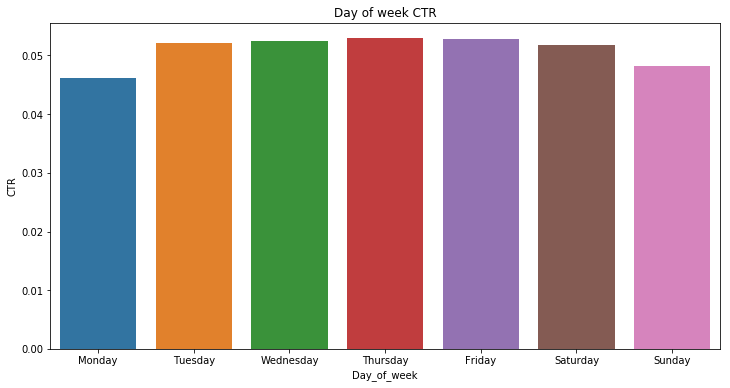

In [192]:
df_click = train[train['Clicks'] == 1]
df_dayofweek = train[['Day_of_week','Clicks']].groupby(['Day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'Clicks': 'impressions'})
df_dayofweek['Clicks'] = df_click[['Day_of_week','Clicks']].groupby(['Day_of_week']).count().reset_index()['Clicks']
df_dayofweek['CTR'] = df_dayofweek['Clicks']/df_dayofweek['impressions']
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='Day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

Прямо скажем не сильно отличается, но как фичу можно оставить

In [193]:
train.drop(["Query", "Date"], axis=1, inplace=True)
test.drop(["Query", "Date", "Id"], axis=1, inplace=True)

Заэнкодим категориальные переменные (если быть честным, они тут все, кроме кликов и показов, категориальные, но речь про
категориальные-текстовые)

In [194]:
train = pd.get_dummies(train, columns=["QueryMatchTypeWithVariant", 
                                      "Device", 'CampaignId', 'Day_of_week'])
test = pd.get_dummies(test, columns=["QueryMatchTypeWithVariant", 
                                      "Device", 'CampaignId', 'Day_of_week'])

In [195]:
scaler = MinMaxScaler()

#train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
#test = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

test.head()

,AdGroupId,KeywordId,AveragePosition,QueryMatchTypeWithVariant_EXACT,QueryMatchTypeWithVariant_EXPANDED,QueryMatchTypeWithVariant_NEAR_EXACT,QueryMatchTypeWithVariant_NEAR_PHRASE,QueryMatchTypeWithVariant_PHRASE,Device_DESKTOP,Device_HIGH_END_MOBILE,...,CampaignId_150950690,CampaignId_150950810,CampaignId_150951290,Day_of_week_Friday,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday
0,24573357890,570188752,1.7,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
1,24573357890,570188752,1.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,24573479450,24155728639,2.0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,24573357890,570188752,1.9,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,7953845090,29883687951,1.0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0


In [196]:
y = train['Clicks']
train.drop(['Clicks'], axis=1, inplace=True)

In [200]:
def save_prediction(prediction, file_name):
    pd.DataFrame({"Id":list(range(0, 87807)),"ClickProbability":prediction}).to_csv(file_name,
                                                                                          index=False,header=True)

In [211]:
train_split, test_split, y_train_split, y_test_split = train_test_split(train, y, 
                                                                        test_size=0.1, random_state=42)

In [212]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_split, y_train_split)
lgb_eval = lgb.Dataset(test_split, y_test_split, reference=lgb_train)

In [219]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.3,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

Start training...
[1]	valid_0's binary_logloss: 0.18402
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.174785
[3]	valid_0's binary_logloss: 0.168376
[4]	valid_0's binary_logloss: 0.163584
[5]	valid_0's binary_logloss: 0.159696
[6]	valid_0's binary_logloss: 0.156588
[7]	valid_0's binary_logloss: 0.15399
[8]	valid_0's binary_logloss: 0.151823
[9]	valid_0's binary_logloss: 0.150009
[10]	valid_0's binary_logloss: 0.148438
[11]	valid_0's binary_logloss: 0.146997
[12]	valid_0's binary_logloss: 0.145776
[13]	valid_0's binary_logloss: 0.144744
[14]	valid_0's binary_logloss: 0.1438
[15]	valid_0's binary_logloss: 0.142949
[16]	valid_0's binary_logloss: 0.142254
[17]	valid_0's binary_logloss: 0.141613
[18]	valid_0's binary_logloss: 0.141046
[19]	valid_0's binary_logloss: 0.140569
[20]	valid_0's binary_logloss: 0.140135
[21]	valid_0's binary_logloss: 0.139751
[22]	valid_0's binary_logloss: 0.139399
[23]	valid_0's binary_logloss: 0.139109
[24]	valid_0

[209]	valid_0's binary_logloss: 0.136172
[210]	valid_0's binary_logloss: 0.136161
[211]	valid_0's binary_logloss: 0.136172
[212]	valid_0's binary_logloss: 0.136182
[213]	valid_0's binary_logloss: 0.136193
[214]	valid_0's binary_logloss: 0.136183
[215]	valid_0's binary_logloss: 0.136192
[216]	valid_0's binary_logloss: 0.136195
[217]	valid_0's binary_logloss: 0.136201
[218]	valid_0's binary_logloss: 0.136208
[219]	valid_0's binary_logloss: 0.136209
[220]	valid_0's binary_logloss: 0.136202
[221]	valid_0's binary_logloss: 0.136194
[222]	valid_0's binary_logloss: 0.136186
[223]	valid_0's binary_logloss: 0.136176
[224]	valid_0's binary_logloss: 0.136178
[225]	valid_0's binary_logloss: 0.136179
[226]	valid_0's binary_logloss: 0.136186
[227]	valid_0's binary_logloss: 0.136178
[228]	valid_0's binary_logloss: 0.136176
[229]	valid_0's binary_logloss: 0.136159
[230]	valid_0's binary_logloss: 0.136175
[231]	valid_0's binary_logloss: 0.136175
[232]	valid_0's binary_logloss: 0.136187
[233]	valid_0's 

[412]	valid_0's binary_logloss: 0.136551
[413]	valid_0's binary_logloss: 0.136569
[414]	valid_0's binary_logloss: 0.136578
[415]	valid_0's binary_logloss: 0.13658
[416]	valid_0's binary_logloss: 0.136582
[417]	valid_0's binary_logloss: 0.13658
[418]	valid_0's binary_logloss: 0.136583
[419]	valid_0's binary_logloss: 0.136589
[420]	valid_0's binary_logloss: 0.136578
[421]	valid_0's binary_logloss: 0.136573
[422]	valid_0's binary_logloss: 0.136587
[423]	valid_0's binary_logloss: 0.13661
[424]	valid_0's binary_logloss: 0.136617
[425]	valid_0's binary_logloss: 0.136639
[426]	valid_0's binary_logloss: 0.136637
[427]	valid_0's binary_logloss: 0.136639
[428]	valid_0's binary_logloss: 0.136644
[429]	valid_0's binary_logloss: 0.136649
[430]	valid_0's binary_logloss: 0.136662
[431]	valid_0's binary_logloss: 0.136648
[432]	valid_0's binary_logloss: 0.136668
[433]	valid_0's binary_logloss: 0.13667
[434]	valid_0's binary_logloss: 0.136682
[435]	valid_0's binary_logloss: 0.136681
[436]	valid_0's bina

[614]	valid_0's binary_logloss: 0.136853
[615]	valid_0's binary_logloss: 0.136841
[616]	valid_0's binary_logloss: 0.136844
[617]	valid_0's binary_logloss: 0.136838
[618]	valid_0's binary_logloss: 0.13683
[619]	valid_0's binary_logloss: 0.136831
[620]	valid_0's binary_logloss: 0.136829
[621]	valid_0's binary_logloss: 0.136834
[622]	valid_0's binary_logloss: 0.136829
[623]	valid_0's binary_logloss: 0.136819
[624]	valid_0's binary_logloss: 0.136814
[625]	valid_0's binary_logloss: 0.136814
[626]	valid_0's binary_logloss: 0.136813
[627]	valid_0's binary_logloss: 0.136812
[628]	valid_0's binary_logloss: 0.136814
[629]	valid_0's binary_logloss: 0.13682
[630]	valid_0's binary_logloss: 0.136826
[631]	valid_0's binary_logloss: 0.136824
[632]	valid_0's binary_logloss: 0.136828
[633]	valid_0's binary_logloss: 0.136846
[634]	valid_0's binary_logloss: 0.136862
[635]	valid_0's binary_logloss: 0.136876
[636]	valid_0's binary_logloss: 0.136883
[637]	valid_0's binary_logloss: 0.136891
[638]	valid_0's bi

In [220]:
print(gbm.best_score)
print(gbm.best_iteration)

defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.13602456304119037}})
189


In [221]:
labels= gbm.predict(test)

In [222]:
print(labels)

[0.02866495 0.0706276  0.00576201 ... 0.06884683 0.05867553 0.0057969 ]


In [223]:
save_prediction(labels, 'lgbm.csv')